In [102]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
from bertopic import BERTopic
import seaborn as sns

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [52]:
sentences = ["This is an example sentence", "Each sentence is converted"]
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2", output_hidden_states=True)
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

In [97]:
def cls_pooling(model_output):
    return model_output.last_hidden_state[:, 0, :]


def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output["last_hidden_state"]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def max_pooling(model_output, attention_mask):
    last_hidden_state = model_output["last_hidden_state"]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    last_hidden_state[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
    max_embeddings = torch.max(last_hidden_state, 1)[0]
    return max_embeddings

In [83]:
tweets = pd.read_csv("./data/tweets.csv")

In [98]:
texts = tweets["text"][:500].tolist()

In [100]:
encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
attention_mask = encoded_input["attention_mask"]

In [101]:
with torch.no_grad():
    model_output = model(**encoded_input)

embeddings_cls = cls_pooling(model_output)
embeddings_mean = mean_pooling(model_output, attention_mask)

In [117]:
topic_model = BERTopic()
topics_cls, probs_cls = topic_model.fit_transform(texts, embeddings_cls.numpy())
topics_mean, probs_mean = topic_model.fit_transform(texts, embeddings_mean.numpy())

<Axes: ylabel='Count'>

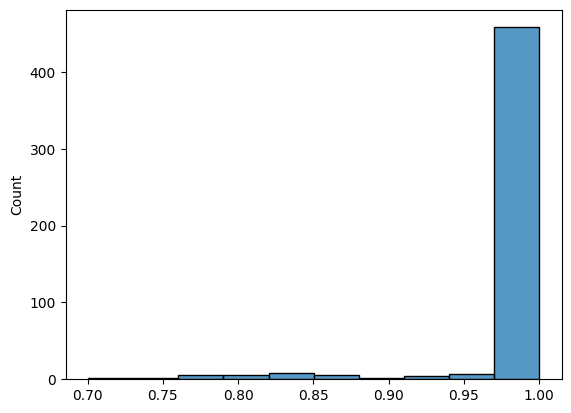

In [128]:
sns.histplot(probs_mean)

<Axes: ylabel='Count'>

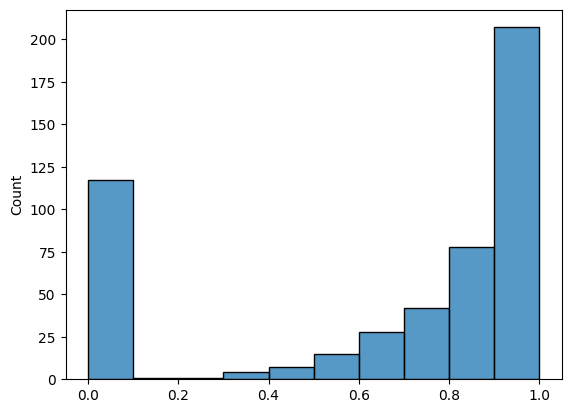

In [127]:
sns.histplot(probs_cls)